# CWRU Experiments
## Imports

In [1]:
import pandas as pd
import numpy as np

import lib.transformers as tfs
from sklearn.pipeline import Pipeline

from lib.models import Ganomaly1d, Ganomaly2d, GanomalyFE, GanomalyNet
from lib.visualization import GANomalyBoard, rename_tensorboard_key

from skorch.callbacks import PassthroughScoring, ProgressBar
import torch

from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
import tensorflow

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lib.others import create_dataset

from lib.others import build_model
from lib.visualization import lineplot_comparison

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwruData0 = pd.read_parquet('data/cwru0.parquet')
cwruData1 = pd.read_parquet('data/cwru1.parquet')

cwruData = pd.concat([cwruData0, cwruData1])

## Settings

In [3]:
# torch.manual_seed(0)
# torch.cuda.manual_seed(0)
# np.random.seed(0)

## Creating Datasets

In [4]:
normal_features, normal_labels = create_dataset(cwruData, feature_columns = ['fanEndData', 'driveEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Normal Baseline'], sampleRate = [12000])
normal_features_train, normal_features_test, normal_labels_train, normal_labels_test = train_test_split(normal_features, normal_labels, train_size = 400, test_size= 451, random_state = 0)

ball_features, ball_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Ball Fault'], sampleRate = [12000])
inner_features, inner_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Inner Race Fault'], sampleRate = [12000])
outer_features, outer_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Outer Race Fault'], sampleRate = [12000])


labels_test = pd.concat([ball_labels, inner_labels, outer_labels, normal_labels_test])
features_test = pd.concat([ball_features, inner_features, outer_features, normal_features_test])

normal_features_test = np.array(normal_features_test.to_list())
normal_features_train = np.array(normal_features_train.to_list())

# GridSearchCV

In [5]:
search_parameters = {
    'Model__module__w_app': list(range(0, 31, 30)),
}

In [6]:
#ganomaly_gs = GridSearchCV(model_fft, search_parameters, refit=False, cv=2)

## Building and training the different Models

In [7]:
# model settings
n_z = 600
n_channels = 1
n_feature_maps = 32

fraud_weight = 1
appearant_weight = 1
latent_weight = 1
lambda_weight = 0.5

# training settings
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
n_gpus = 0
workers = 2
batch_size = 16
max_epochs = 3
lr = 0.0001
beta1 = 0.5
beta2 = 0.999

# extra callbacks
callbacks = []

# run number
run = 1000

### Time Series

In [8]:
gan_time_series =\
build_model(
    model = Ganomaly1d,
    
    # model parameters
    input_size = 3136, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # logging parameters
    suffix = 'timeseries' + str(run),
    plot_type = 'lineplot', 
    plot_shape = 3136, 
    plot_latent_shape =600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks
)

In [9]:
pipeline_time_series = \
Pipeline(steps=[
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('reshaper', tfs.ArrayReshaper((1, 3136))),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_time_series)
               ])

In [10]:
for _ in range(3):
    pipeline_time_series.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.4070                0.6429        0.7448            1.7075         0.5557        2.3504  15.1518
      2            0.3066                0.4167        0.7511            1.2875         0.2298        1.7042  14.9572
      3            0.2050                0.1400        0.7585            1.1035         0.1401        1.2435  14.3050
Re-initializing module because the following parameters were re-set: appearant_weight, fraud_weight, input_size, lambda_weight, latent_weight, n_channels, n_fm_discriminator, n_fm_generator, n_gpus, n_z.
  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001DB7FB8F550>
Traceback (most recent call last):
  File "C:\Users\jlsachse\Anaconda3\envs\AnomalyGan\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "C:\Users\jlsachse\Anaconda3\envs\AnomalyGan\lib\site-packages\torch\utils\data\dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\jlsachse\Anaconda3\envs\AnomalyGan\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\jlsachse\Anaconda3\envs\AnomalyGan\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
KeyboardInterrupt: 


### Stacked Time Series

In [11]:
gan_stacked_time_series =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 56, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # logging parameters
    suffix = 'stacked_timeseries' + str(run), 
    plot_type = 'lineplot', 
    plot_shape = 3136, 
    plot_latent_shape =600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks
)

In [12]:
pipeline_stacked_time_series = \
Pipeline(steps=[
                ('reshaper', tfs.ArrayReshaper((1, 56, 56))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_stacked_time_series)
               ])

In [13]:
pipeline_stacked_time_series.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.4772                0.4103        0.7392            1.5302         0.3138        1.9405  12.3197
      2            0.3544                0.0789        0.7391            1.1368         0.0433        1.2157  14.0027
      3            0.2335                0.0339        0.7381            0.9928         0.0212        1.0267  12.7433


Pipeline(steps=[('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000001DB083FF670>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000001DB083FF070>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000001DB083FF7C0>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly2d(
    (fraud_loss): BCELoss()
    (appearant_loss): L1Loss...
          (pyramid-128-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (pyramid-256-batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-256-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-conv): Conv2d(256, 600, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
    )
  

### Frequency Spectrum

In [14]:
gan_frequency_spectrum =\
build_model(
    model = Ganomaly1d,
    
    # model parameters
    input_size = 1568, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'frequency_spectrum' + str(run), 
    plot_type = 'lineplot', 
    plot_shape = 1568, 
    plot_latent_shape = 600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks
)

In [15]:
pipeline_frequency_spectrum = \
Pipeline(steps=[
                ('fourier_transform', tfs.ArrayFFT()),
                ('reshaper', tfs.ArrayReshaper((1, 1568))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_frequency_spectrum)
               ])

In [16]:
pipeline_frequency_spectrum.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss     dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  ------
      1            0.0732                0.3867        0.7082            0.8703         0.0888        1.2569  7.0345
      2            0.0401                0.1238        0.7087            0.7634         0.0146        0.8872  7.8331
      3            0.0264                0.0708        0.7085            0.7449         0.0100        0.8157  6.7776


Pipeline(steps=[('fourier_transform',
                 <lib.transformers.ArrayFFT object at 0x000001DB0BC1C250>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000001DB0BC1C6D0>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000001DB0BC1CD00>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000001DB0BC1C610>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[i...
          (pyramid-relu-64): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-64-128-convt): Conv1d(64, 128, kernel_size=(16,), stride=(4,), bias=False)
          (pyramid-128-batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-relu-128): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-128-1-convt): Conv1d(128, 600, kernel_size=(9,), stride=(1,), bias=False)
        )
      )
    )
  )

### Spectrogram

In [17]:
gan_spectrogram =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 56, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'spectrograms' + str(run),
    plot_type = 'image', 
    plot_shape = 56, 
    plot_latent_shape =600, 
    n_samples = 36,

    # extra callbacks
    callbacks = callbacks
)

In [18]:
pipeline_spectrogram = \
Pipeline(steps=[
                ('stft_transform', tfs.ArraySTFT()),
                ('reshaper', tfs.ArrayReshaper((1, 56, 56))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_spectrogram)
               ])

In [19]:
pipeline_spectrogram.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.1093                0.2927        0.7516            1.0325         0.1716        1.3252  12.9529
      2            0.0717                0.0561        0.7539            0.8473         0.0217        0.9034  13.6073
      3            0.0526                0.0310        0.7532            0.8213         0.0155        0.8523  13.4334


Pipeline(steps=[('stft_transform',
                 <lib.transformers.ArraySTFT object at 0x000001DB0A2FE520>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000001DB0A2FE6D0>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000001DB0A2FE760>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000001DB0A2FE7C0>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[ini...
          (pyramid-128-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (pyramid-256-batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-256-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-conv): Conv2d(256, 600, kernel_size=(3, 3), stride=(1, 1), bias=False)
   

### Feature Extraction

In [20]:
gan_feature_extraction =\
build_model(
    model = GanomalyFE,
    
    # model parameters
    input_size = 4, 
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'feature_extraction' + str(run), 
    plot_type = 'barplot', 
    plot_shape = 16, 
    plot_latent_shape = 32, 
    n_samples = 4,

    # extra callbacks
    callbacks = callbacks
)

In [21]:
pipeline_feature_extraction = \
Pipeline(steps=[
                ('feature_extractor', tfs.FeatureExtractor()),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('reshaper', tfs.ArrayReshaper((1, 4, 4))),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_feature_extraction)
              ])

In [22]:
pipeline_feature_extraction.fit(normal_features_train)

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss     dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  ------
      1            0.0856                0.4772        0.5954            0.6816         0.0006        1.1587  2.2754
      2            0.0856                0.4471        0.6046            0.6906         0.0003        1.1377  2.2844
      3            0.0855                0.4163        0.6112            0.6969         0.0002        1.1132  2.3328


Pipeline(steps=[('feature_extractor',
                 <lib.transformers.FeatureExtractor object at 0x000001DB0AF356A0>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000001DB0AF354F0>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000001DB0AF353A0>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000001DB0AF350D0>),
                ('model',
                 <class 'lib.models.Ganomal...
      )
      (fake_encoder): EncoderFE(
        (main): Sequential(
          (initial-conv-1-4): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), bias=False)
          (initial-4-batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (initial-4-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-conv-4-8): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1), bias=False)
        )
      )
    )
  ),
))])

## Results


### Timeseries

In [23]:
features_test = np.array(features_test.tolist())
predictions = pipeline_time_series.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

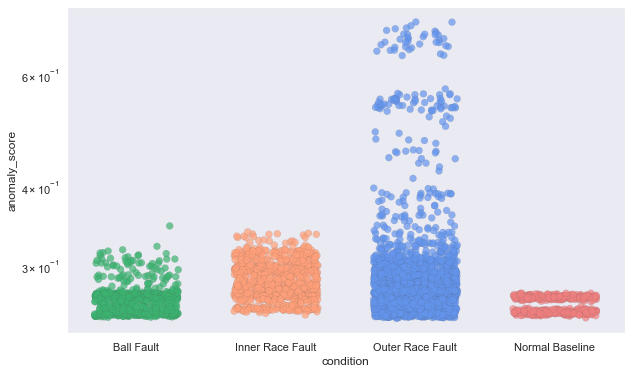

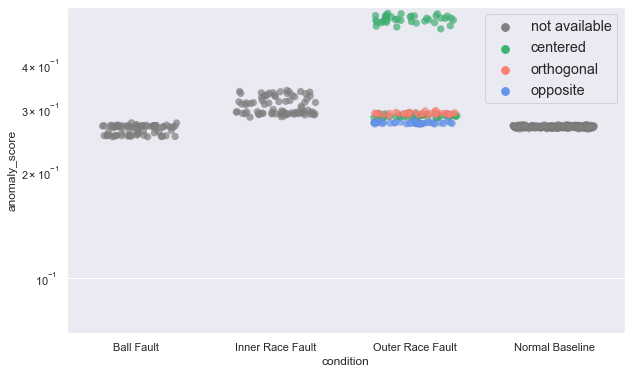

In [24]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]


fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

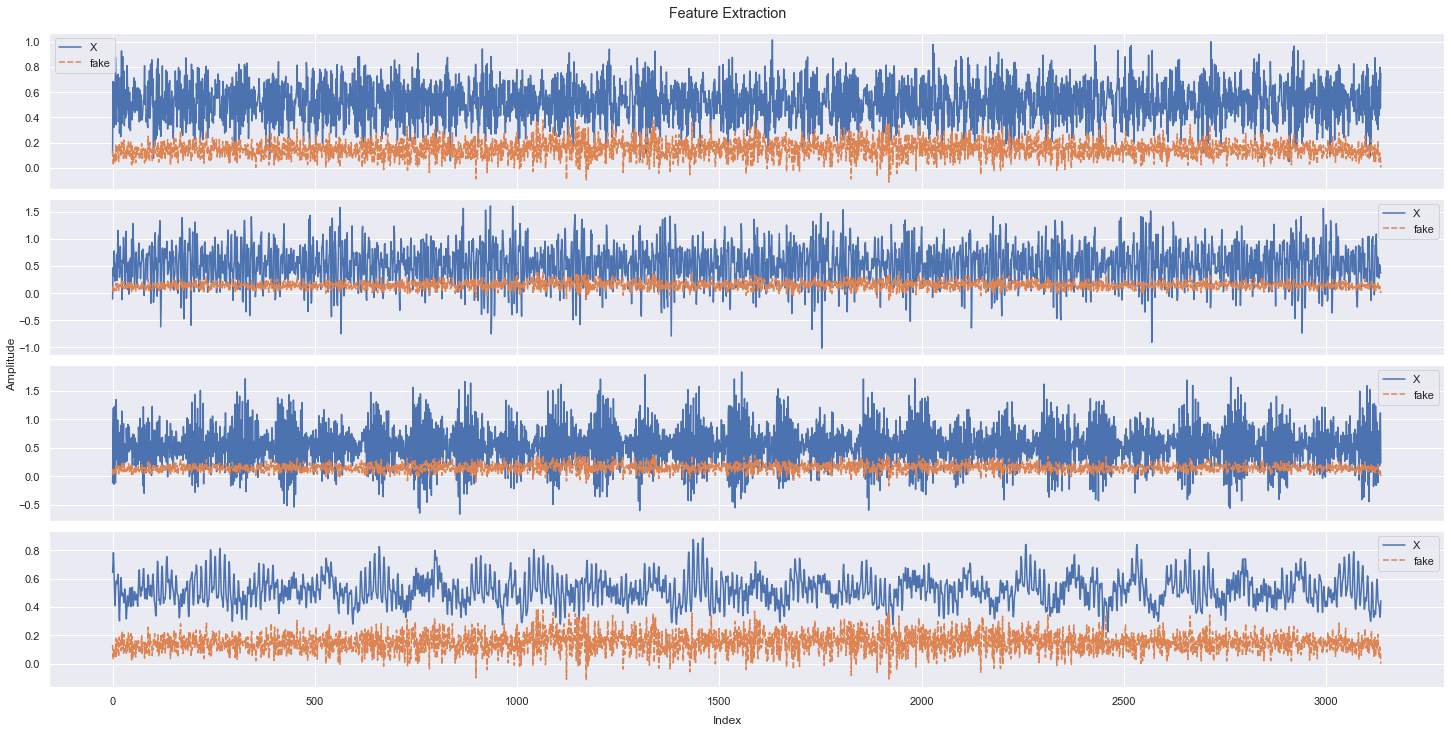

In [25]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

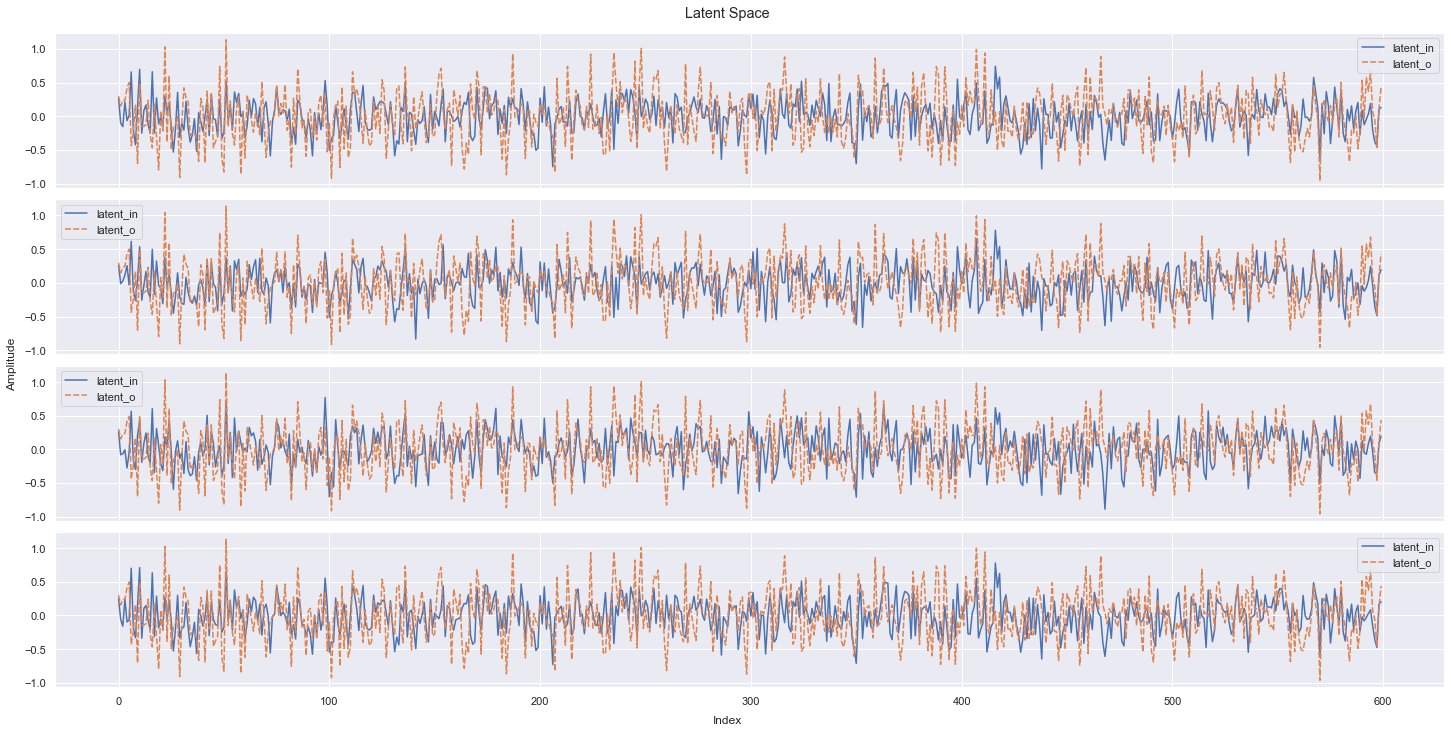

In [26]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### Stacked Timeseries

In [27]:
features_test = np.array(features_test.tolist())
predictions = pipeline_stacked_time_series.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

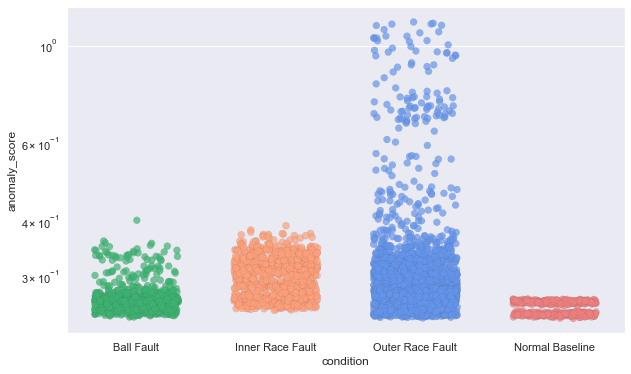

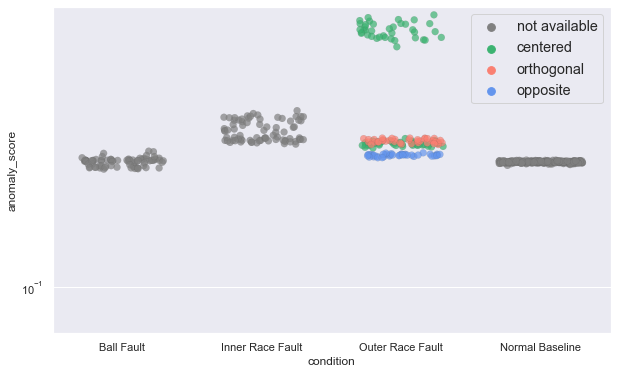

In [28]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

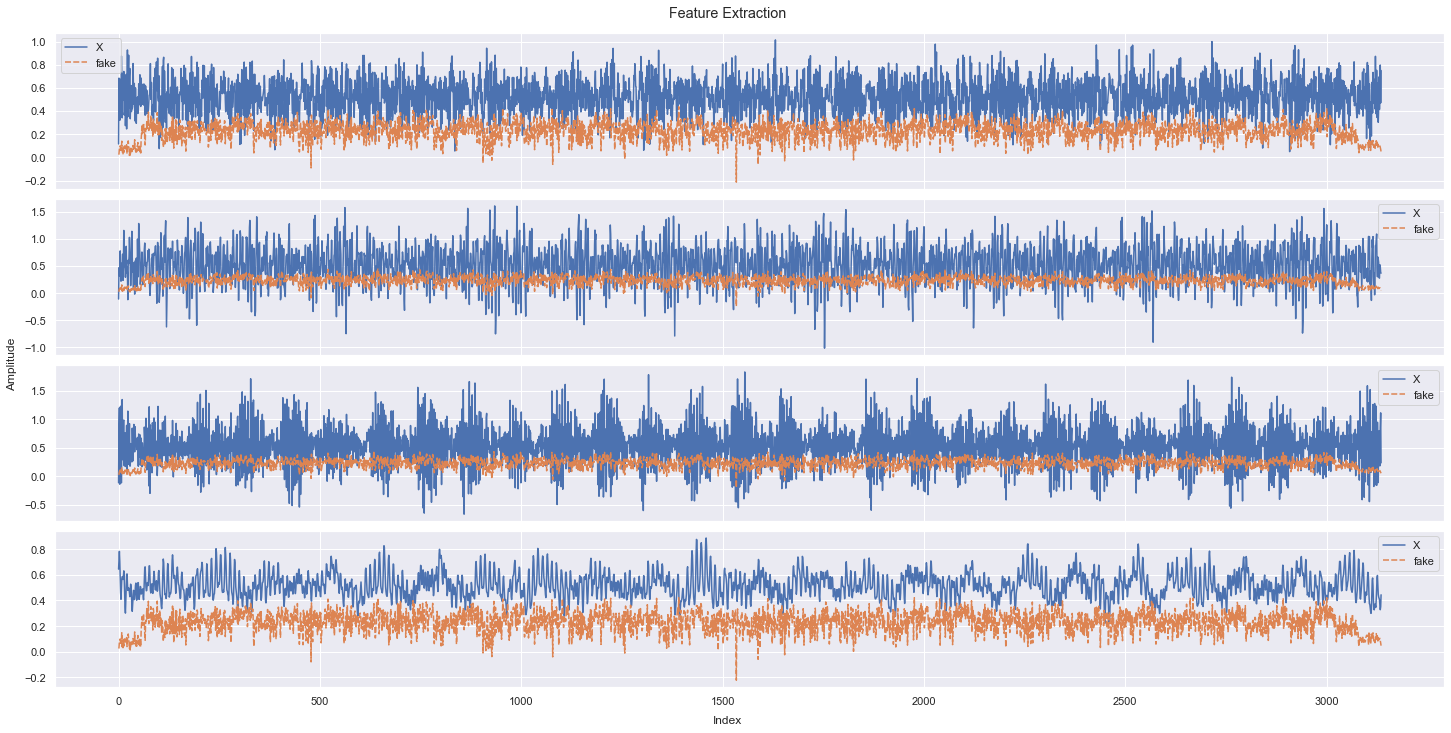

In [29]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

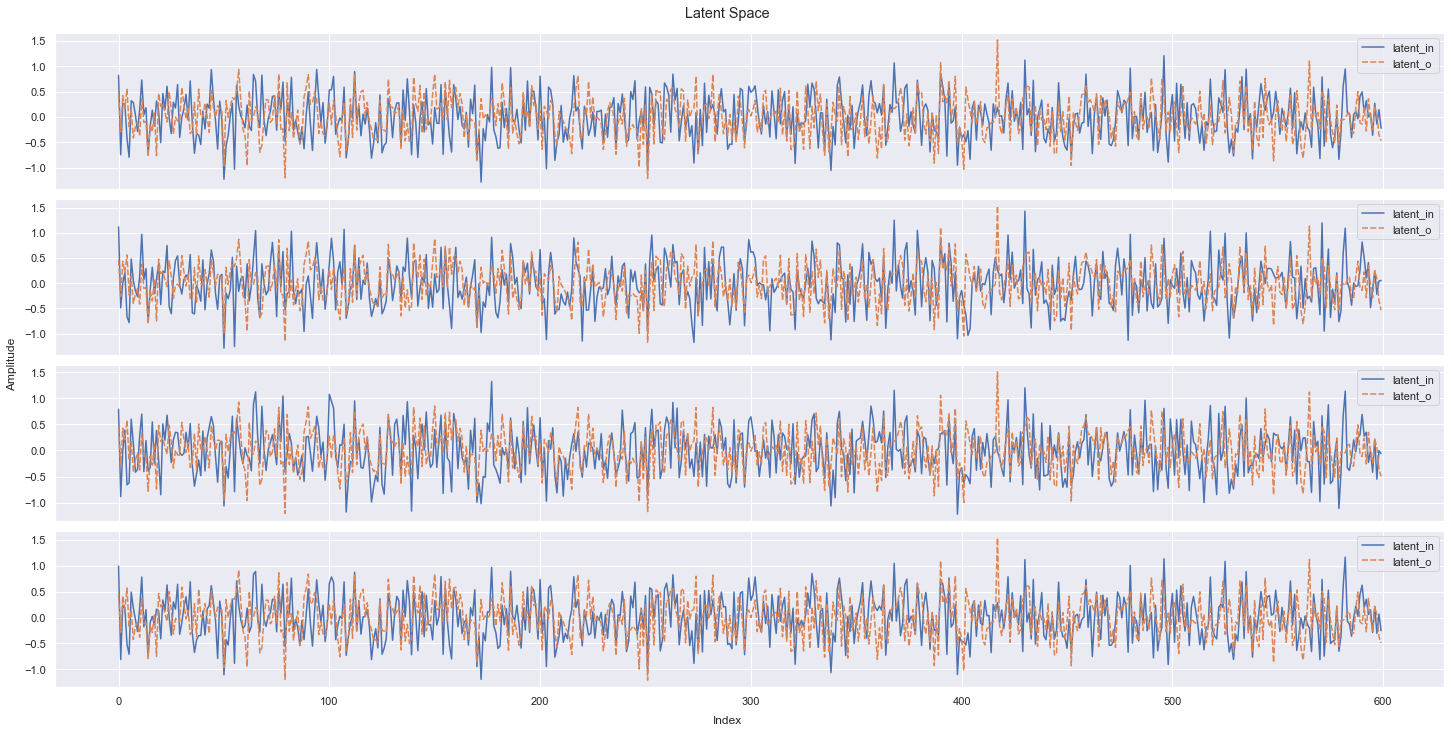

In [30]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### FFT

In [31]:
features_test = np.array(features_test.tolist())
predictions = pipeline_frequency_spectrum.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

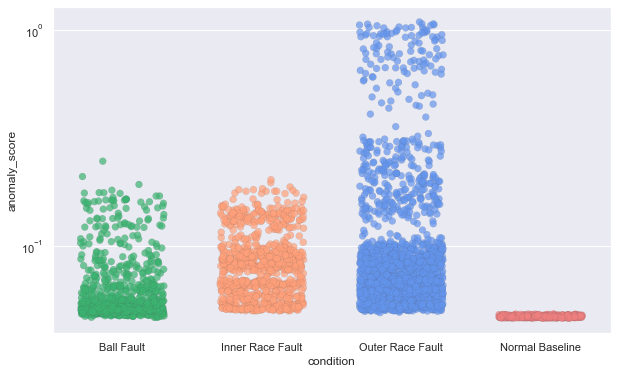

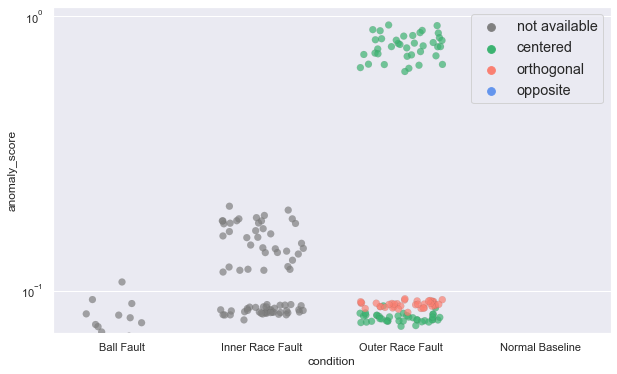

In [32]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

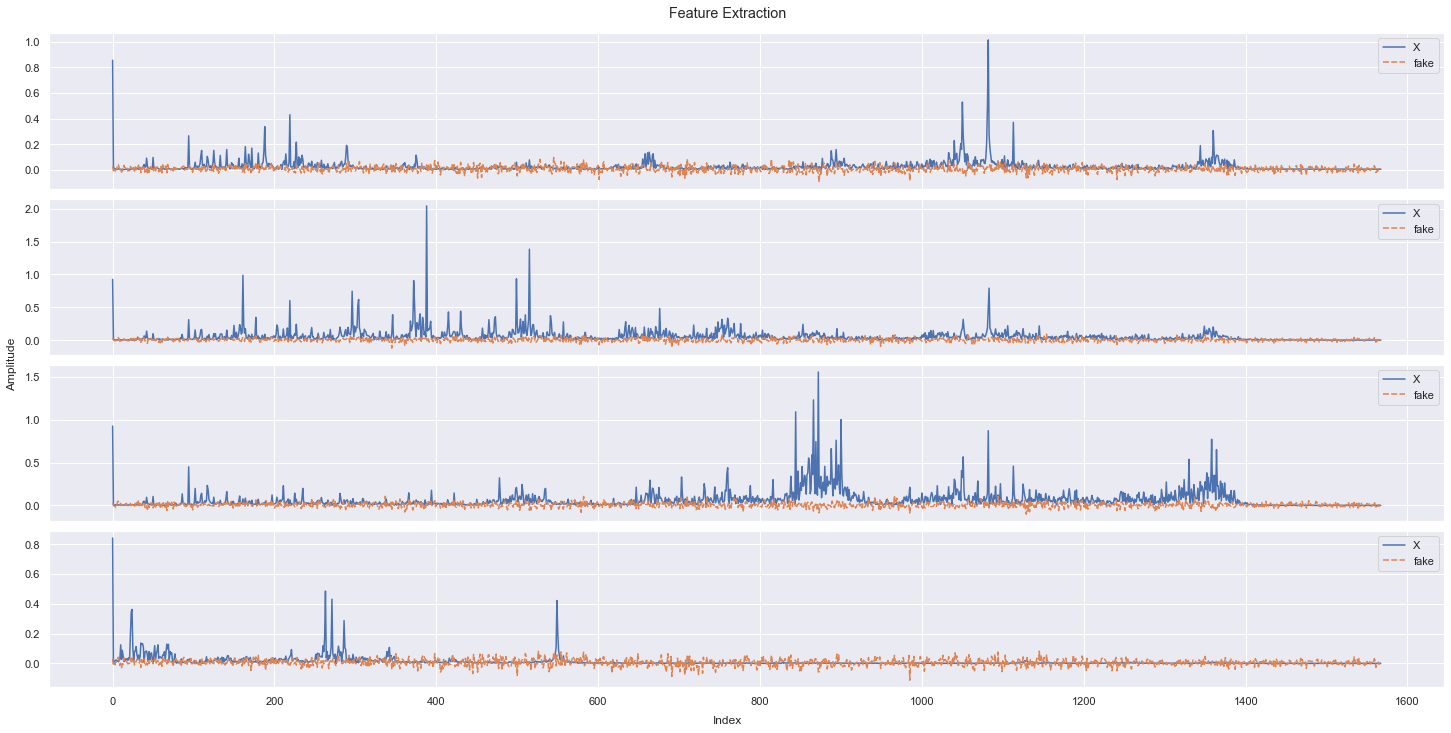

In [33]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

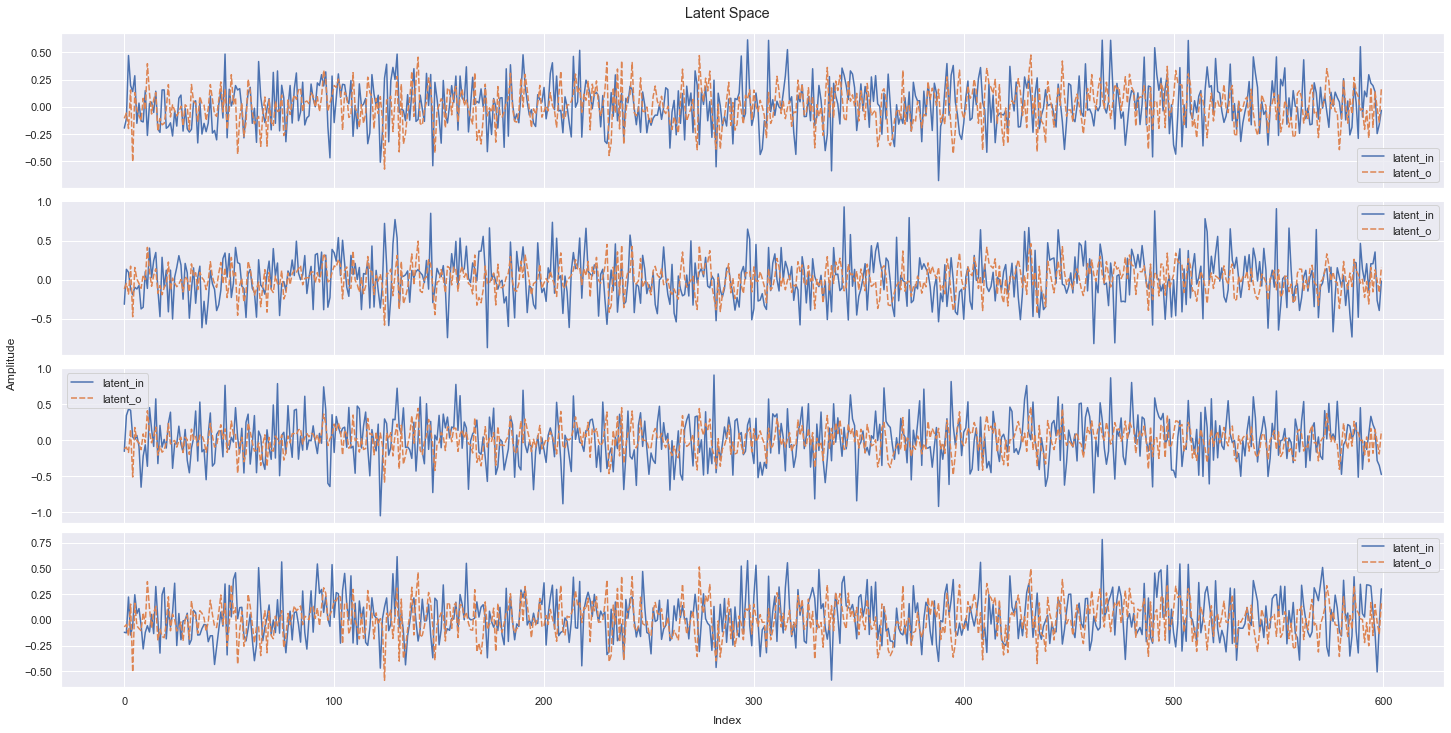

In [34]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### STFT

In [35]:
features_test = np.array(features_test.tolist())
predictions = pipeline_spectrogram.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

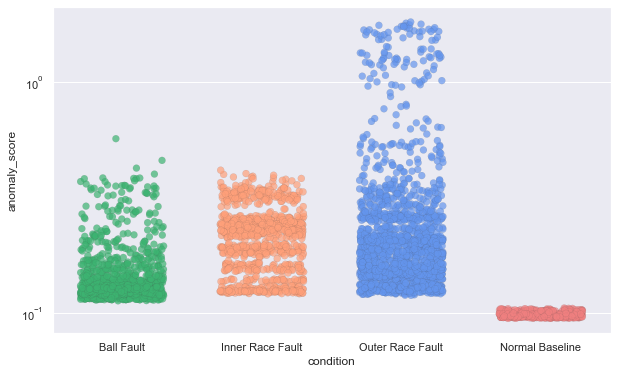

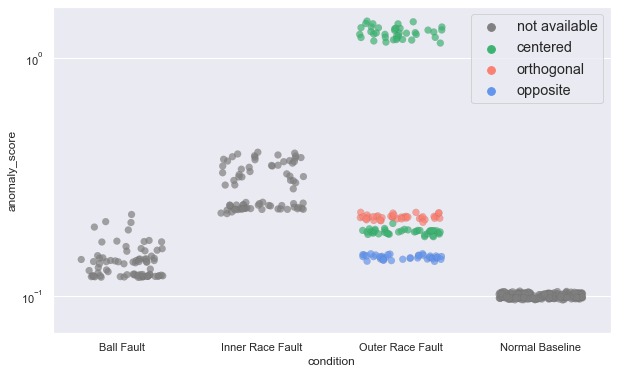

In [36]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

### Feature Extraction

In [37]:
features_test = np.array(features_test.tolist())
predictions = pipeline_feature_extraction.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

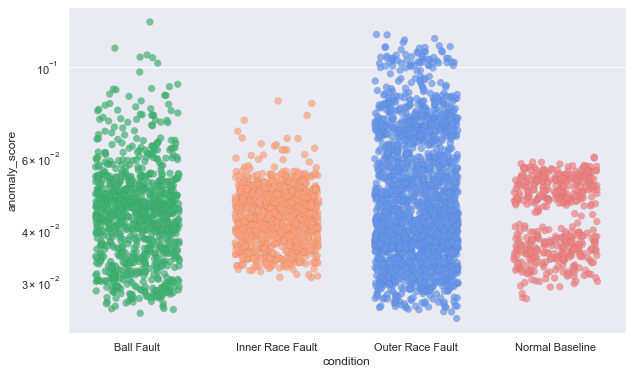

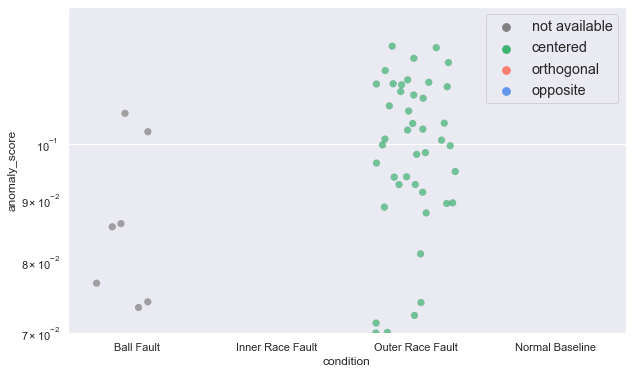

In [38]:
sns.set_style('darkgrid')

sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')